# NLP Project

Urdu to Roman Urdu Transliterator

Help Reference:
https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt

### This notebook contains the training, evaluation, and testing of the model for sentences of length <= 10

In [1]:
# imports 
import csv
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Concatenate, Attention
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.seq2seq import BasicDecoder
from keras.losses import SparseCategoricalCrossentropy
import time as time
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import matplotlib.pyplot as plt
import warnings
import random
!pip install evaluate
import evaluate
!pip install rouge_score
import numpy as np
import heapq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load datasets
with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_train_roman.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_train_roman = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_train_urdu.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_train_urdu = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_test_roman.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_test_roman = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

with open('/content/drive/MyDrive/NLP Project/cleaned_data/buckets_test_urdu.csv', 'r') as f:
    reader = csv.reader(f)
    buckets_test_urdu = [[[int(num) for num in sublist.split(',')] for sublist in row] for row in reader]

In [4]:
# just printing to see if i didnt mess up anything
len(buckets_train_roman[1])

108258

In [5]:
# ok, i didn't mess up anything - now time to build the tensorflow dataset for the model

current_index = 1 # this line is to be changed for each file

# hyperparameters for the dataset
buffer_size = 32000
batch_size = 64

# make tensorflow train and test dataset from the buckets, shuffle the train data and convert all datasets to batches of size 64 (as done in the paper)
train_dataset = tf.data.Dataset.from_tensor_slices((buckets_train_urdu[current_index], buckets_train_roman[current_index]))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((buckets_test_urdu[current_index], buckets_test_roman[current_index]))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [6]:
# load the tokenizers
with open('/content/drive/MyDrive/NLP Project/tokenizer_roman.pkl', 'rb') as f:
    tokenizer_roman_string = f.read()

tokenizer_roman = pickle.loads(tokenizer_roman_string)

with open('/content/drive/MyDrive/NLP Project/tokenizer_urdu.pkl', 'rb') as f:
    tokenizer_urdu_string = f.read()

tokenizer_urdu = pickle.loads(tokenizer_urdu_string)

In [7]:
# hyperparameters for the model
vocab_tar_size = len(tokenizer_roman.word_index) + 1
vocab_inp_size = len(tokenizer_urdu.word_index) + 1
embedding_dim = 256
units = 1024
steps_per_epoch = 17300 

## Model Architecture:

In [8]:
# code used from the help reference and modified a bit to fit our needs

In [9]:
# encoder
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, num_layers=3):
      super(Encoder, self).__init__()
      self.batch_sz = batch_sz
      self.enc_units = enc_units
      self.embedding = Embedding(vocab_size, embedding_dim)
      self.num_layers = num_layers
      # bidirectional lstms, number of layers is passed from arguments
      self.lstms = [Bidirectional(LSTM(self.enc_units, return_sequences=True, return_state=True)) for i in range(self.num_layers)]

  # custom feedforward function
  def call(self, x, hidden):
    x = self.embedding(x)
    states = hidden
    new_states = []
    # for each bi_lstm layer, pass in the initial_state from the encoder's hidden state and then get the forward activation, concatenate backward and forward activation
    for i in range(self.num_layers):
        forward_init_state = states[i*4:i*4+2]
        backward_init_state = states[i*4+2:i*4+4]
        x, forward_h, forward_c, backward_h, backward_c = self.lstms[i](x, initial_state=forward_init_state + backward_init_state)
        h = Concatenate()([forward_h, backward_h])
        c = Concatenate()([forward_c, backward_c])
        new_states.extend([h, c])
    return x, new_states

  def build_initial_states(self, batch_sz):
      return [tf.zeros((batch_sz, self.enc_units)) for _ in range(self.num_layers * 4)]  # 4 initial states (2 for each lstm layer) per layer


In [10]:
# decoder
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, num_layers):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        # lstm layers
        self.lstms = [LSTM(self.dec_units, return_sequences=True, return_state=True) for _ in range(self.num_layers)]
        # output layer
        self.fc = Dense(vocab_size)
        # attention layer
        self.attention = Attention()

    # feedforward function 
    def call(self, x, hidden, enc_output):
        # get the context vector from the query asked and the output of the encoder
        query = tf.expand_dims(hidden[0], 1)
        context_vector = self.attention([query, enc_output])
        # add the context vector as input to the decoder
        x = self.embedding(x)
        x = tf.concat([context_vector, x], axis=-1)

        states = hidden
        for i in range(self.num_layers):
            x, h, c = self.lstms[i](x, initial_state=states[i*2:i*2+2])
            states[i*2:i*2+2] = [h, c]

        output = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc(output)

        return x, states

    def build_initial_states(self, enc_hidden):
        return enc_hidden

In [11]:
# define Adam optimizer and use params given in paper
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

## Train and Evaluate Model

In [12]:
# define the loss function - code used from help reference
def loss_function(real, pred):
  # multi-class classification
  cross_entropy = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  # ignore the effect of padded 0s
  mask = tf.logical_not(tf.math.equal(real, 0))  
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

In [13]:
# helper function to train each batch
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    # pass input to encoder, get the output from the encoder and pass as input to the decoder
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * batch_size, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

        batch_loss = (loss / int(targ.shape[1]))
        # update training parameters (kind of like theta := theta + gradient)
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss

In [14]:
# main training loop - code modified from help reference
import time as time

EPOCHS = 15
train_loss = []
num_layers = 2

encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size, num_layers)
decoder = Decoder(vocab_tar_size, embedding_dim, units*2, batch_size, num_layers)
print('total batches:', len(train_dataset))
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.build_initial_states(batch_size)
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        train_loss.append(batch_loss)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch // 100} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

total batches: 1691
Epoch 1 Batch 0 Loss 6.2469
Epoch 1 Batch 1 Loss 4.2466
Epoch 1 Batch 2 Loss 3.9152
Epoch 1 Batch 3 Loss 3.8013
Epoch 1 Batch 4 Loss 3.8534
Epoch 1 Batch 5 Loss 3.8189
Epoch 1 Batch 6 Loss 4.0218
Epoch 1 Batch 7 Loss 3.9583
Epoch 1 Batch 8 Loss 3.7587
Epoch 1 Batch 9 Loss 3.6304
Epoch 1 Batch 10 Loss 3.7665
Epoch 1 Batch 11 Loss 3.8224
Epoch 1 Batch 12 Loss 3.9083
Epoch 1 Batch 13 Loss 3.5639
Epoch 1 Batch 14 Loss 3.7009
Epoch 1 Batch 15 Loss 3.6634
Epoch 1 Batch 16 Loss 3.5514
Epoch 1 Loss 0.3711
Time taken for 1 epoch 1497.09 sec

Epoch 2 Batch 0 Loss 3.5026
Epoch 2 Batch 1 Loss 3.6420
Epoch 2 Batch 2 Loss 3.4259
Epoch 2 Batch 3 Loss 3.1534
Epoch 2 Batch 4 Loss 3.3558
Epoch 2 Batch 5 Loss 3.3514
Epoch 2 Batch 6 Loss 3.4160
Epoch 2 Batch 7 Loss 3.3172
Epoch 2 Batch 8 Loss 3.4548
Epoch 2 Batch 9 Loss 3.1576
Epoch 2 Batch 10 Loss 3.2865
Epoch 2 Batch 11 Loss 3.3021
Epoch 2 Batch 12 Loss 3.1475
Epoch 2 Batch 13 Loss 3.0404
Epoch 2 Batch 14 Loss 3.3295
Epoch 2 Batch 15

In [55]:
# beam search:
import math 

def predict_beam(test_bucket):
  output = []
  # iterate through each example
  for i, (roman_sentence, urdu_sentence) in enumerate(test_bucket):
    # print(i, "examples done,", len(test_bucket) - i, "remain")
    # convert the sentence to its numeric sequence to give to the model
    urdu_sequence = [tokenizer_urdu.word_index[i] if i in tokenizer_urdu.word_index else tokenizer_urdu.word_index['<OOV>'] for i in urdu_sentence.split(' ')]
    urdu_sequence = pad_sequences([urdu_sequence], padding='post')
    # convert the sequence to a tensor
    urdu_sequence = tf.convert_to_tensor(urdu_sequence)
    inference_batch_size = urdu_sequence.shape[0]
    # call the encoder
    enc_start_state = [tf.zeros((inference_batch_size, units)) for _ in range(num_layers * 4)]
    enc_out, enc_hidden = encoder(urdu_sequence, enc_start_state)
    # create input for decoder
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * inference_batch_size, 1)
    max_len_output = 20
    # get the input sequence for the decoder
    input_sequence = dec_input.numpy()
    # initialize the candidates from beam search, each row is of type: (candidate_sequence, log_probability)
    beam_candidates = [[input_sequence, 0.0]]
    beam_width = 5
    for t in range(max_len_output):
      # store the next candidates
      next_candidates = []
      # for each sequence in the current list of candidates
      for seq, score in beam_candidates:
        seq = tf.convert_to_tensor(seq)
        dec_input = tf.expand_dims(tf.convert_to_tensor([seq.numpy()[0][-1]]) if len(seq) > 0 else tokenizer_roman.word_index['<start>'], 0)
        # get the predictions for each token from the decoder for this sequence
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out)
        # normalize probabilities to prevent negative values
        probs = tf.nn.softmax(predictions, axis=1)
        min_len = len(roman_sentence.split(' '))
        # punish printing <end> before len(roman_sentence) by assigning it a very log value
        if t < min_len:
          end_token_inx = tokenizer_roman.word_index['<end>']
          mask = tf.one_hot(end_token_inx,probs.shape[-1], dtype=tf.float32)
          probs = tf.where(mask == 1, tf.ones_like(probs) * -float('inf'), probs)
        # store the top k most probable ones - beam search
        top_k_preds = tf.math.top_k(probs[0], k=beam_width)
        for current_beam in range(beam_width):
          predicted_index = top_k_preds.indices[current_beam].numpy()
          candidate_sequence = tf.concat([seq, tf.convert_to_tensor([[predicted_index]])], axis=1)
          candidate_score = score + math.log(top_k_preds.values[current_beam])
          next_candidates.append([candidate_sequence, candidate_score])
        
      # sort candidates by their score
      sorted_candidates = sorted(next_candidates, key=lambda tup: tup[1], reverse=True)
      # get the top beam_width candidates
      beam_candidates = sorted_candidates[:beam_width]
      # exit loop if all candidates have generated <end> token
      # if all([tokenizer_roman.index_word[c[0].numpy()[0][-1]] == '<end>' for c in beam_candidates]):
      #   break

    # best candidate
    best_sequence = beam_candidates[0][0]
    result = ' '.join([tokenizer_roman.index_word[idx] for idx in best_sequence.numpy()[0]])
    output.append((roman_sentence.replace('<start>', '').replace('<end>', '').strip(), result.replace('<start>', '').replace('<end>', '').strip()))
  return output


# greedy search:
def predict_greedy(test_dataset):
  preds_bucket = []
  # for each example in the test set
  for i, tup in enumerate(test_dataset):
    # call the evaluate_sentence func on the urdu text's batch
    result = evaluate_sentence(tup[1]).replace("<start>", "").replace("<end>", "").strip()
    expected = tup[0].replace("<start>", "").replace("<end>", "").strip()
    preds_bucket.append((expected, result))
    if i % 100 == 0:
      print(i, "test examples done,", len(test_dataset) - i, "left.")
  print('all done!')
  return preds_bucket

def evaluate_sentence(sentence):
    inputs = [tokenizer_urdu.word_index[i] if i in tokenizer_urdu.word_index else tokenizer_urdu.word_index['<OOV>'] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], padding='post')
    inputs = tf.convert_to_tensor(inputs)
    inference_batch_size = inputs.shape[0]
    result = '<start>'
    enc_start_state = [tf.zeros((inference_batch_size, units)) for _ in range(num_layers * 4)] 
    enc_out, enc_hidden = encoder(inputs, enc_start_state)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer_roman.word_index['<start>']] * inference_batch_size, 1)
    
    for t in range(40):

      predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_out) 
        
      # just use argmax to get the token with the highest probability
      predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        
      result += tokenizer_roman.index_word[predicted_id] + ' '
        
      if tokenizer_roman.index_word[predicted_id] == '<end>':
          return result.strip()
        
      # pass the predicted token as the next input to the decoder
      dec_input = tf.expand_dims([predicted_id] * inference_batch_size, 1)
      
    return result


In [22]:
# helper function to calculate bleu score
def calculate_bleu_score(preds):
  # Split the dataset into expected translations and predicted translations.
  expected = [pair[0] for pair in preds]
  predicted = [pair[1] for pair in preds]

  # # Calculate the BLEU score for each sentence and average BLEU score for all test sentences
  bleu_scores = [sentence_bleu([ref.split()], pred.split()) for ref, pred in zip(predicted, expected)]
  avg_bleu_score = corpus_bleu([[ref.split()] for ref in expected], [pred.split() for pred in predicted])

  return avg_bleu_score * 100

In [23]:
def loss_graph(train_loss):
  train_steps = list(range(len(train_loss)))
  # Create the figure and axis objects
  fig, ax = plt.subplots()
  # Plot the data
  ax.plot(train_steps, train_loss, color='blue')
  # Set the title and axis labels
  ax.set_title('Training Loss')
  ax.set_xlabel('Training Steps')
  ax.set_ylabel('Training Loss')
  # Show the plot
  plt.show()

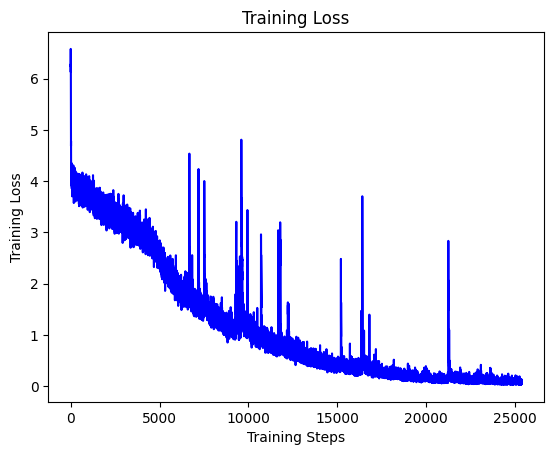

In [24]:
# plot the training loss graph
loss_graph(train_loss)

In [25]:
# load the test data
import pickle

with open('/content/drive/MyDrive/NLP Project/test_buckets.pickle', 'rb') as f:
    test_buckets = pickle.load(f)

In [56]:
# calculate the prediction
preds_bucket_beam = predict_beam(test_buckets[current_index][0:100])
preds_bucket_beam

[('jamaat yani imam ke ilawa kam se kam teen mard',
  'jamaat yani se jari hain ke liye jari se hai zila zila'),
 ('azal se le kar kaamil taq ki badolat ka ghulamana salam qubool kar !',
  'azal se hub salam kar rahay ko qubool yi aamad zila ! ki hain ! zila  !'),
 ('ke be abbu tha magar dost tha purana woh',
  'ke be hai dost par grijoyshn ka terhan hai zila zila'),
 ('aur ab ki imandaar kisi kyun mein nahi kabhi ki cheezein khoobiyan sun - hwa karti theen',
  'aur ab jaakar sun - anjaam di liya di ki zaroorat ki wajah ki terhan tahiya liya sakti hain'),
 ('waisay guria se to kya aap khailtay hon ge bnta kar letay hain tarmeem kar ke : )',
  'waisay guria khailtay satke se tahiya ) ) hain ) zila ) hain zila . ) farmaya ) umeed )'),
 ('ki sach hai naya zee hum sarka ray ka kha te hain',
  'ki sach - e baghaawat se hain hain ki tahiya par award hain ki'),
 ('palat yahan se ! mra sheesha saaf nikla hai',
  'palat yahan dil hai zila zila zila zila zila zila zila'),
 ('woh khud saraab hai 

In [57]:
# quantitaive analysis - bleu score of model, rouge score
print('beam search')
bleu_score = calculate_bleu_score(preds_bucket_beam)
rouge = evaluate.load('rouge')
expected = [pair[0] for pair in preds_bucket_beam]
predicted = [pair[1] for pair in preds_bucket_beam]
rouge_score = rouge.compute(predictions=predicted, references=expected)
print("BLEU SCORE OF BUCKET SIZE 20:", bleu_score)
print("ROUGE SCORE OF BUCKET SIZE 20:", rouge_score)

beam search


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU SCORE OF BUCKET SIZE 20: 1.2043543072055763e-76
ROUGE SCORE OF BUCKET SIZE 20: {'rouge1': 0.3108560672602514, 'rouge2': 0.0962900489216751, 'rougeL': 0.2890372374392871, 'rougeLsum': 0.28934142892869763}


In [28]:
# calculate the prediction
preds_bucket_greedy = predict_greedy(test_buckets[current_index][0:100])
preds_bucket_greedy

0 test examples done, 100 left.
all done!


[('jamaat yani imam ke ilawa kam se kam teen mard',
  'jamaat yani imam ke ilawa kam se kam teen mard'),
 ('azal se le kar kaamil taq ki badolat ka ghulamana salam qubool kar !',
  'azal se le kar kaamil taq ki badolat ka suhaag salam qubool kar !'),
 ('ke be abbu tha magar dost tha purana woh',
  'ke be abbu tha magar dost tha akhbar woh waisa'),
 ('aur ab ki imandaar kisi kyun mein nahi kabhi ki cheezein khoobiyan sun - hwa karti theen',
  'aur ab ki partners kisi kyun mein nahi kabhi ki cheezein larnay sun - hwa karti theen'),
 ('waisay guria se to kya aap khailtay hon ge bnta kar letay hain tarmeem kar ke : )',
  'waisay guria se to kya aap khailtay hon ge ras kar letay hain gole kar ke : )'),
 ('ki sach hai naya zee hum sarka ray ka kha te hain',
  'ki sach hai naya zee hum music ray ka kha te hain'),
 ('palat yahan se ! mra sheesha saaf nikla hai',
  'palat yahan se ! mra sheesha saaf nikla hai'),
 ('woh khud saraab hai ouron ko aabb kya day ga',
  'woh khud maanguu hai ouron ko 

In [29]:
# quantitaive analysis - bleu score of model, rouge score
print('greedy search')
bleu_score = calculate_bleu_score(preds_bucket_greedy)
rouge = evaluate.load('rouge')
expected = [pair[0] for pair in preds_bucket_greedy]
predicted = [pair[1] for pair in preds_bucket_greedy]
rouge_score = rouge.compute(predictions=predicted, references=expected)
print("BLEU SCORE OF BUCKET SIZE 20:", bleu_score)
print("ROUGE SCORE OF BUCKET SIZE 20:", rouge_score)

greedy search


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU SCORE OF BUCKET SIZE 20: 74.00313046096531
ROUGE SCORE OF BUCKET SIZE 20: {'rouge1': 0.9008228826857693, 'rouge2': 0.82553781430192, 'rougeL': 0.9005644124322528, 'rougeLsum': 0.9011126384580325}


In [30]:
# qualitative analysis - lets see a few example sentences and their transliterations
# since greedy gave better performance on quant. metrics, we are just showing the sentences using greedy approach.
for i in range(10):
  inx = random.randint(0, len(preds_bucket_greedy))
  r, u = test_buckets[current_index][inx]
  print('Urdu Sentence:', u.replace('<start>', '').replace('<end>', '').strip())
  print('Actual Roman Urdu Sentence:', r.replace('<start>', '').replace('<end>', '').strip())
  orig, pred = preds_bucket_greedy[inx]
  print('Predicted Roman Urdu Sentence:', pred.replace('<start>', '').replace('<end>', '').strip())
  print()

Urdu Sentence: اس سا ے سے صفی اب محروم ہو چکا ہے
Actual Roman Urdu Sentence: is ke se Safi ab technology ho chuka hai
Predicted Roman Urdu Sentence: is ke se tanqeedi ab technology ho chuka hai

Urdu Sentence: کل تو ہم نے سلام کیا کس نے جواب تک نہیں دیا
Actual Roman Urdu Sentence: kal to hum ne salam kya kis ne jawab taq nahi diya
Predicted Roman Urdu Sentence: kal to hum ne salam kya kis ne jawab taq nahi diya

Urdu Sentence: دن میں مرتبہ فرض نمازوں کے ل ے موذن یہ فریضہ انجام دیتا ہے
Actual Roman Urdu Sentence: din mein martaba farz namazon ke liye muezzin yeh fareeza injaam deta hai
Predicted Roman Urdu Sentence: din mein martaba farz war ke liye haraval ki sarparasti injaam deta hai

Urdu Sentence: ایل او سی پر تجارت اور بس سروس بحال
Actual Roman Urdu Sentence: ail o si par tijarat aur Dehli bas taluqaat
Predicted Roman Urdu Sentence: ail o si par tijarat aur dehli bas baal

Urdu Sentence: اور ہاں اس محفل میں انے سے پہلے دل دماغ سبھی فرج میں رکھ اتی ہوں
Actual Roman Urdu Sentence: a